<a href="https://colab.research.google.com/github/sogand73/OCT-Classification/blob/main/representative_dictionary_learning_for_OCT(Macular_Dataset_Heidelberg).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
from PIL import Image
import cv2
import shutil
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import MiniBatchDictionaryLearning

In [ ]:
!pip install ultralytics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Data preparing for Dictionary Learning

In [3]:
!sudo apt-get install unrar


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
# Dataset collected from Macular Dataset Heidelberg --------> 600 train (100 validation), 200 test for each class
!unrar x '/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/Dataset.rar'

In [ ]:
# @title Selection of some images as the dataset for dictionary learning (open and store)

In [16]:
shutil.rmtree('/content/oct_my_dictl_dataset')

In [17]:
!mkdir '/content/oct_my_dictl_dataset'


In [20]:
#classes = ['NORMAL', 'DME', 'DRUSEN', 'CNV']
classes = ['Normal', 'DME', 'AMD']
for subfolder in classes:
  dictl_subfolder = os.path.join('/content/oct_my_dictl_dataset/',subfolder)

  os.makedirs(dictl_subfolder, exist_ok=True)

In [61]:
# Define source and destination directories
#dataset_folder = '/content/OCT2017 /train/'  # Replace with your source folder path
dataset_folder = '/content/Dataset/Train/'

destination_folder = '/content/oct_my_dictl_dataset/'  # Replace with your destination folder path
images =[]
for subfolder in ['Normal', 'DME', 'AMD']:
  # List files in the source folder
  source_folder = os.path.join(dataset_folder, subfolder) + '/'
  files_to_copy = os.listdir(source_folder)

  # Copy each image file from the source folder to the destination folder
  for file_name in files_to_copy[:10]:
    if file_name.endswith('.TIFF'):  # Specify the image file formats
          source_path = os.path.join(source_folder, file_name)
          destination_path = os.path.join(destination_folder, subfolder) + '/'
          shutil.copy(source_path, destination_path)
          img = Image.open(os.path.join(destination_path, file_name)) # This returns an image object
          #print(img.mode)
          #img = img.convert('RGB')
          img = np.asarray(img) # convert it to ndarray
          img = cv2.resize(img, (512, 512))
          images.append(img)
#return np.array(images)
          #print(f"Copied: {file_name}")






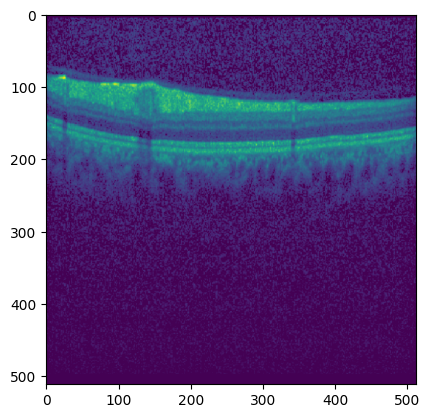

In [62]:
plt.imshow(images[1])

In [ ]:
#@title dictionary Learning Processs

In [63]:
# Load dictionary learning images
image_data = np.asarray(images)
n_images, height, width = image_data.shape

In [70]:
# Flatten the image data
X = image_data.reshape((n_images, height * width))

# Explicitly cast the array to float before division
X = X.astype(float)

# Rescale pixel values to the range [0, 1] for MiniBatchDictionaryLearning
X /= 255.0


# CLASSES: 'NORMAL', 'DME', 'AMD'
X_NORMAL, X_DME, X_AMD = X[:10], X[10:20], X[20:30]

In [25]:
# Create a dictionary learning model for all data classes
n_components = 100  # Number of atoms in the dictionary
alpha = 1.0  # Sparsity controlling parameter
batch_size = 5  # Number of samples per mini-batch
n_iter = 100  # Number of iterations

dl_model = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter)


# Fit the model to the flattened NORMAL image data
dl_model.fit(X)
ATOMS = dl_model.components_
X_tr = dl_model.transform(X)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


0.44733333333333336
3.2991355074941395e-12


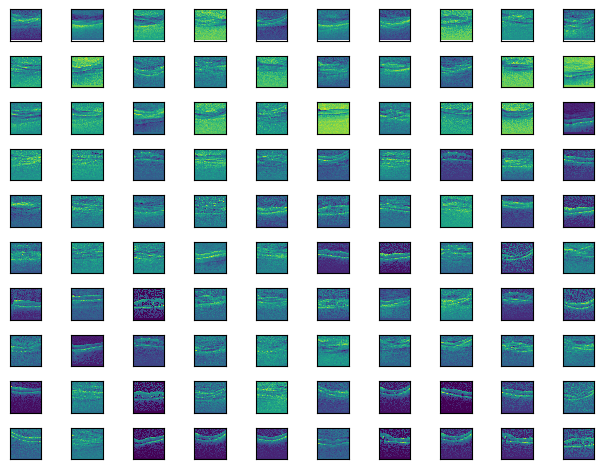

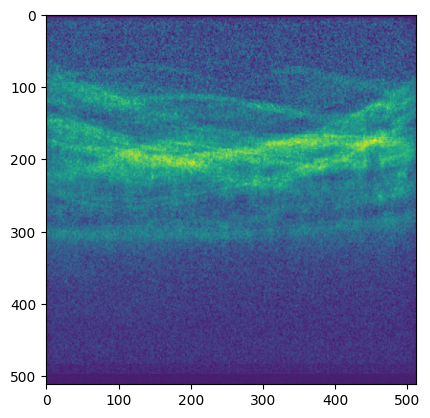

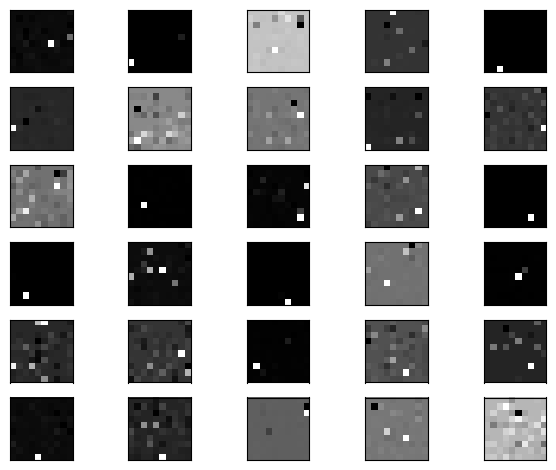

In [27]:
#All data classes

#Feature extraction percent
print(np.mean(X_tr == 0))
X_hat = X_tr @ dl_model.components_
print(np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1)))

#############################################

# Visualize learned dictionary atoms (representatives)
representatives = ATOMS
fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.flatten()

for i in range(n_components):
    axes[i].imshow(representatives[i].reshape((height, width))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


#################################

plt.imshow(representatives[0].reshape((height, width))*255)

#################################

# Visualize transformed images
representatives = X_tr
fig, axes = plt.subplots(nrows=6, ncols=5)
axes = axes.flatten()

for i in range(X_tr.shape[0]):
    axes[i].imshow(representatives[i].reshape((10, 10))*255, cmap = 'gray', interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


In [71]:
# Create a dictionary learning model for NORMAL data
n_components = 100  # Number of atoms in the dictionary
alpha = 0.8  # Sparsity controlling parameter
batch_size = 3  # Number of samples per mini-batch
n_iter = 100  # Number of iterations

dl_model_NORMAL = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter)

# #Normalized data
# X_NORMAL -= np.mean(X_NORMAL, axis=0)
# X_NORMAL /= np.std(X_NORMAL, axis=0)

# Fit the model to the flattened NORMAL image data
dl_model_NORMAL.fit(X_NORMAL)
ATOMS_NORMAL = dl_model_NORMAL.components_
X_NORMAL_tr = dl_model_NORMAL.transform(X_NORMAL)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


In [72]:
# Create a dictionary learning model for DME data
n_components = 100  # Number of atoms in the dictionary
alpha = 0.8  # Sparsity controlling parameter
batch_size = 3  # Number of samples per mini-batch
n_iter = 100  # Number of iterations

dl_model_DME = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter)

#Normalized data
# X_DME -= np.mean(X_DME, axis=0)
# X_DME /= np.std(X_DME, axis=0)

# Fit the model to the flattened DME image data
dl_model_DME.fit(X_DME)
ATOMS_DME = dl_model_DME.components_
X_DME_tr = dl_model_DME.transform(X_DME)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


In [73]:
# Create a dictionary learning model for AMD data
n_components = 100  # Number of atoms in the dictionary
alpha = 0.8  # Sparsity controlling parameter
batch_size = 3  # Number of samples per mini-batch
n_iter = 100  # Number of iterations

dl_model_AMD = MiniBatchDictionaryLearning(n_components=n_components, alpha=alpha, batch_size=batch_size, n_iter=n_iter)

#Normalized data
# X_AMD -= np.mean(X_AMD, axis=0)
# X_AMD /= np.std(X_AMD, axis=0)

# Fit the model to the flattened AMD image data
dl_model_AMD.fit(X_AMD)
ATOMS_AMD = dl_model_AMD.components_
X_AMD_tr = dl_model_AMD.transform(X_AMD)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:2303: FutureWarning: 'n_iter' is deprecated in version 1.1 and will be removed in version 1.4. Use 'max_iter' and let 'n_iter' to its default value instead. 'n_iter' is also ignored if 'max_iter' is specified.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(


In [74]:
!mkdir '/content/atoms'


In [76]:
classes = ['NORMAL', 'DME', 'AMD']
for subfolder in classes:
  dictl_subfolder = os.path.join('/content/atoms/',subfolder)

  os.makedirs(dictl_subfolder, exist_ok=True)

In [224]:

#atoms save as an image

for atom in [[ATOMS_NORMAL,'NORMAL'], [ATOMS_DME,'DME'], [ATOMS_AMD,'AMD']]:
  for i in range(n_components):
    atoms_save = atom[0][i].reshape((512, 512))*255
    atoms_save = atoms_save.astype(np.uint8)
    destination_atom_folder = os.path.join('/content/atoms/', atom[1], str(i)+'.jpeg')
    cv2.imwrite(destination_atom_folder, atoms_save)

0.676
3.2216645828758714e-12


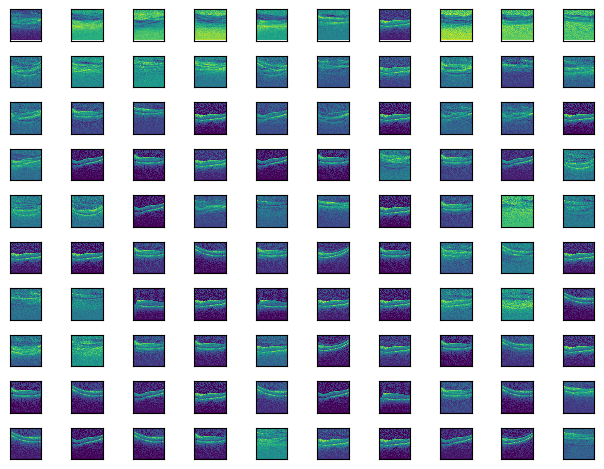

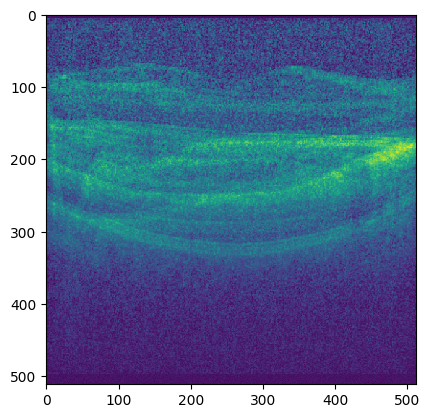

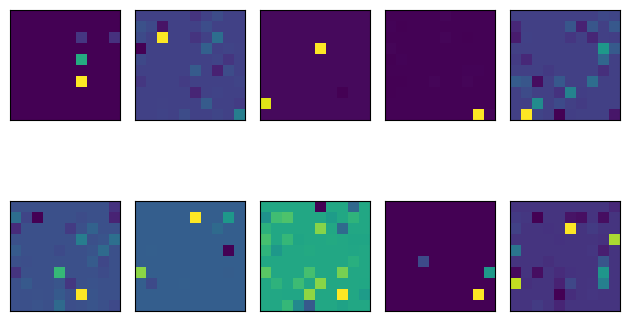

In [81]:
#NORMAL data

#Feature extraction percent
print(np.mean(X_NORMAL_tr == 0))
X_NORMAL_hat = X_NORMAL_tr @ dl_model_NORMAL.components_
print(np.mean(np.sum((X_NORMAL_hat - X_NORMAL) ** 2, axis=1) / np.sum(X_NORMAL ** 2, axis=1)))

#############################################

# Visualize learned dictionary atoms (representatives)
representatives = ATOMS_NORMAL
fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.flatten()

for i in range(n_components):
    axes[i].imshow(representatives[i].reshape((height, width))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


#################################

plt.imshow(representatives[0].reshape((height, width))*255, interpolation='nearest')

#################################

# Visualize transformed images
representatives = X_NORMAL_tr
fig, axes = plt.subplots(nrows=2, ncols=5)
axes = axes.flatten()

for i in range(X_NORMAL_tr.shape[0]):
    axes[i].imshow(representatives[i].reshape((10, 10))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


0.713
3.702210774316028e-12


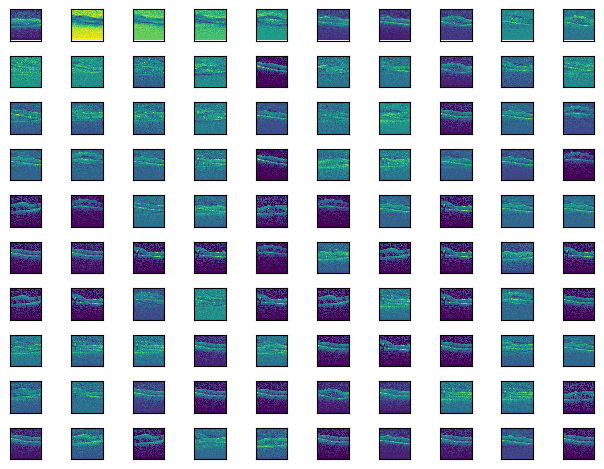

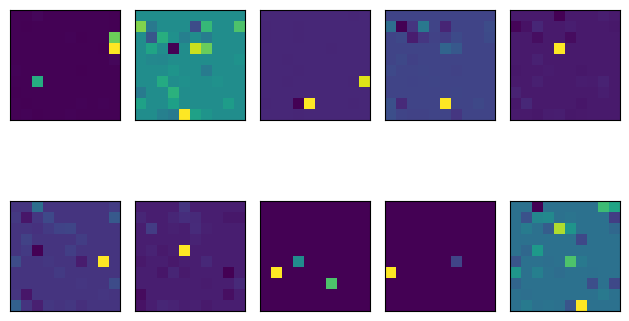

In [82]:
#DME data

#Feature extraction percent
print(np.mean(X_DME_tr == 0))
X_DME_hat = X_DME_tr @ dl_model_DME.components_
print(np.mean(np.sum((X_DME_hat - X_DME) ** 2, axis=1) / np.sum(X_DME ** 2, axis=1)))

#############################################

# Visualize learned dictionary atoms (representatives)
representatives = ATOMS_DME
fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.flatten()

for i in range(n_components):
    axes[i].imshow(representatives[i].reshape((height, width))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


#################################

plt.imshow(representatives[0].reshape((height, width))*255, interpolation='nearest')

#################################

# Visualize transformed images
representatives = X_DME_tr
fig, axes = plt.subplots(nrows=2, ncols=5)
axes = axes.flatten()

for i in range(X_DME_tr.shape[0]):
    axes[i].imshow(representatives[i].reshape((10, 10))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


0.726
3.2016957744446152e-12


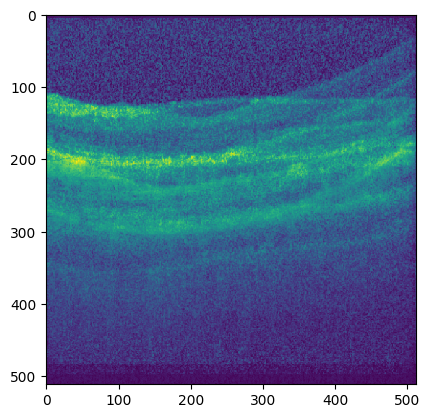

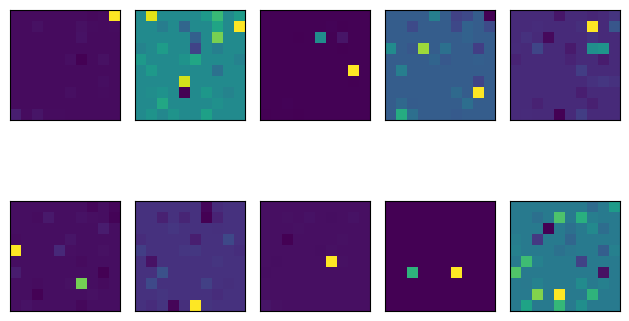

In [83]:
#AMD data

#Feature extraction percent
print(np.mean(X_AMD_tr == 0))
X_AMD_hat = X_AMD_tr @ dl_model_AMD.components_
print(np.mean(np.sum((X_AMD_hat - X_AMD) ** 2, axis=1) / np.sum(X_AMD ** 2, axis=1)))

#############################################

# Visualize learned dictionary atoms (representatives)
representatives = ATOMS_AMD
fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.flatten()

for i in range(n_components):
    axes[i].imshow(representatives[i].reshape((height, width))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


#################################

plt.imshow(representatives[0].reshape((height, width))*255, interpolation='nearest')

#################################

# Visualize transformed images
representatives = X_AMD_tr
fig, axes = plt.subplots(nrows=2, ncols=5)
axes = axes.flatten()

for i in range(X_AMD_tr.shape[0]):
    axes[i].imshow(representatives[i].reshape((10, 10))*255, interpolation='nearest')
    axes[i].set_xticks(())
    axes[i].set_yticks(())

# Adjust layout for better spacing
plt.tight_layout()

plt.show()


In [85]:
#@title Classification using YOLOv8

In [84]:
!pip install ultralytics

In [95]:
shutil.rmtree('/content/oct_my_dataset')

In [96]:
import os
!mkdir '/content/oct_my_dataset'
!mkdir '/content/oct_my_dataset/Train'
!mkdir '/content/oct_my_dataset/Test'
!mkdir '/content/oct_my_dataset/Val'


In [97]:
classes = ['Normal', 'DME', 'AMD']
for subfolder in classes:
  train_subfolder = os.path.join('/content/oct_my_dataset/Train/',subfolder)
  test_subfolder = os.path.join('/content/oct_my_dataset/Test/',subfolder)
  val_subfolder = os.path.join('/content/oct_my_dataset/Val/',subfolder)
  os.makedirs(train_subfolder, exist_ok=True)
  os.makedirs(test_subfolder, exist_ok=True)
  os.makedirs(val_subfolder, exist_ok=True)

In [104]:
import shutil


# Define source and destination directories
dataset_folder = '/content/Dataset'  # Replace with your source folder path

destination_folder = '/content/oct_my_dataset/'  # Replace with your destination folder path

#for folder in [['Train/',500], ['Test/',200], ['val/',100]]:
for folder in [['Train/',600], ['Test/',200]]:
  for subfolder in ['Normal', 'DME', 'AMD']:
    # List files in the source folder
    source_folder = os.path.join(dataset_folder, folder[0], subfolder) + '/'
    files_to_copy = os.listdir(source_folder)

    # Copy each image file from the source folder to the destination folder
    for file_name in files_to_copy[:folder[1]]:
        if file_name.endswith('.TIFF'):  # Specify the image file formats
            source_path = os.path.join(source_folder, file_name)
            destination_path = os.path.join(destination_folder, folder[0], subfolder) + '/'
            shutil.copy(source_path, destination_path)
            #print(f"Copied: {file_name}")


In [108]:
#Separate and store Val data from train data
# Define source and destination directories
dataset_folder = '/content/oct_my_dataset/Train/'  # Replace with your source folder path

destination_folder = '/content/oct_my_dataset/Val/'  # Replace with your destination folder path



for subfolder in ['Normal', 'DME', 'AMD']:
  # List files in the source folder
  source_folder = os.path.join(dataset_folder, subfolder) + '/'
  files_to_copy = os.listdir(source_folder)

  # Copy each image file from the source folder to the destination folder
  for num in range(500,600):
    file_name = files_to_copy[num]
    if file_name.endswith('.TIFF'):  # Specify the image file formats
        source_path = os.path.join(source_folder, file_name)
        destination_path = os.path.join(destination_folder, subfolder) + '/'
        shutil.copy(source_path, destination_path)
        #print(f"Copied: {file_name}")

In [118]:
shutil.rmtree('/content/oct_my_trdataset')

In [119]:
import os
!mkdir '/content/oct_my_trdataset'
!mkdir '/content/oct_my_trdataset/Train'
!mkdir '/content/oct_my_trdataset/Test'
!mkdir '/content/oct_my_trdataset/Val'

In [120]:
classes = ['Normal', 'DME', 'AMD']
for subfolder in classes:
  train_subfolder = os.path.join('/content/oct_my_trdataset/Train/',subfolder)
  test_subfolder = os.path.join('/content/oct_my_trdataset/Test/',subfolder)
  val_subfolder = os.path.join('/content/oct_my_trdataset/Val/',subfolder)
  os.makedirs(train_subfolder, exist_ok=True)
  os.makedirs(test_subfolder, exist_ok=True)
  os.makedirs(val_subfolder, exist_ok=True)

In [121]:
import shutil


# Define source and destination directories
#dataset_folder = '/content/drive/MyDrive/oct_classification/oct_my_dataset'
dataset_folder = '/content/oct_my_dataset'  # Replace with your source folder path

destination_folder = '/content/oct_my_trdataset/'  # Replace with your destination folder path

for folder in [['Train/',500], ['Test/',200], ['Val/',100]]:
  for subfolder in ['Normal', 'DME', 'AMD']:
    # List files in the source folder
    source_folder = os.path.join(dataset_folder, folder[0], subfolder) + '/'
    files_to_copy = os.listdir(source_folder)

    # Copy each image file from the source folder to the destination folder
    for file_name in files_to_copy[:folder[1]]:
        if file_name.endswith('.TIFF'):  # Specify the image file formats
            source_path = os.path.join(source_folder, file_name)
            destination_path = os.path.join(destination_folder, folder[0], subfolder) + '/'
            #shutil.copy(source_path, destination_path)
            img = Image.open(source_path) # This returns an image object
            #print(img.mode)
            #img = img.convert('RGB')
            img = np.asarray(img) # convert it to ndarray
            img = cv2.resize(img, (512, 512))
            img = img.reshape((1, 512 * 512))
            img = img.astype(float)
            img /= 255.0



            if subfolder == 'NORMAL':
              img_tr = dl_model_NORMAL.transform(img)
            elif subfolder == 'DME':
              img_tr = dl_model_DME.transform(img)
            else:
              img_tr = dl_model_AMD.transform(img)



            img_tr2d = img_tr.reshape((10, 10))*255
            img_tr2d = img_tr2d.astype(np.uint8)

            # Save the image to the specified directory
            save_destination = os.path.join(destination_path, file_name)
            #image_to_save.save(save_destination)
            cv2.imwrite(save_destination, img_tr2d)


            #images.append(img_tr2d)
            #print(f"Copied: {file_name}")


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  new_code = orthogonal_mp_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_dict_learning.py:213: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the di

In [122]:
plt.imshow(img_tr2d.reshape((10, 10)), interpolation='nearest')
plt.colorbar()

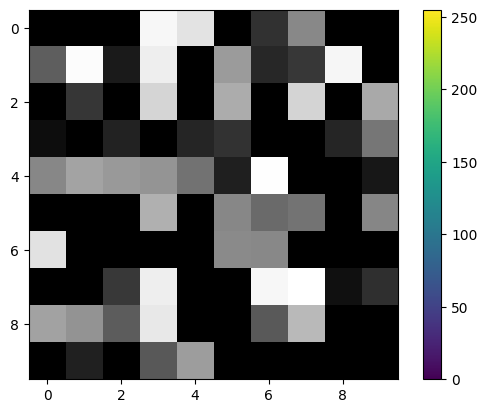

In [123]:
c = cv2.imread(save_destination)
plt.imshow(c, interpolation='nearest')
plt.colorbar()

In [129]:
from ultralytics import YOLO

# Load a model

#model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)
#model = YOLO('/content/runs/classify/train2/weights/best.pt') #Load the initial weights, gained from the former model training on this data (previous line)

model = YOLO('yolov8n-cls.yaml')  # build a new model from YAML
model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)
model = YOLO('yolov8n-cls.yaml').load('yolov8n-cls.pt')  # build from YAML and transfer weights

# Train the model
results = model.train(data='/content/oct_my_trdataset', epochs=50, imgsz=10, batch=64)

Ultralytics YOLOv8.1.5 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=classify, mode=train, model=/content/runs/classify/train2/weights/best.pt, data=/content/oct_my_trdataset, epochs=20, time=None, patience=50, batch=64, imgsz=10, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_lab

train: Scanning /content/oct_my_trdataset/train... 1500 images, 0 corrupt: 100%|██████████| 1500/1500 [00:00<?, ?it/s]
val: Scanning /content/oct_my_trdataset/val... 300 images, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 32 train, 32 val
Using 0 dataloader workers
Logging results to runs/classify/train3
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.69it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.61it/s]

                   all      0.673          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.90it/s]

                   all      0.667          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 10.41it/s]

                   all        0.7          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.54it/s]

                   all       0.66          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 10.06it/s]

                   all      0.687          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.16it/s]

                   all      0.683          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 10.61it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]

                   all       0.66          1



      Epoch    GPU_mem       loss  Instances       Size


      10/20         0G     0.6263         28         32: 100%|██████████| 24/24 [00:07<00:00,  3.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s]

                   all      0.643          1



      Epoch    GPU_mem       loss  Instances       Size


      11/20         0G     0.6399         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.47it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 10.06it/s]

                   all       0.67          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20         0G     0.6563         28         32: 100%|██████████| 24/24 [00:07<00:00,  3.16it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  6.54it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20         0G     0.6567         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 10.01it/s]

                   all       0.68          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20         0G     0.6619         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.66it/s]

                   all      0.683          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20         0G     0.6574         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 10.52it/s]

                   all      0.687          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20         0G     0.6415         28         32: 100%|██████████| 24/24 [00:05<00:00,  4.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]

                   all       0.69          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20         0G     0.6427         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.56it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 10.15it/s]

                   all      0.663          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20         0G     0.6217         28         32: 100%|██████████| 24/24 [00:06<00:00,  4.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  8.81it/s]

                   all      0.653          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20         0G     0.6395         28         32: 100%|██████████| 24/24 [00:07<00:00,  3.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.33it/s]


                   all      0.673          1

      Epoch    GPU_mem       loss  Instances       Size


      20/20         0G     0.6274         28         32: 100%|██████████| 24/24 [00:06<00:00,  3.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  9.01it/s]

                   all      0.653          1



20 epochs completed in 0.040 hours.
Optimizer stripped from runs/classify/train3/weights/last.pt, 3.0MB
Optimizer stripped from runs/classify/train3/weights/best.pt, 3.0MB

Validating runs/classify/train3/weights/best.pt...
Ultralytics YOLOv8.1.5 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 73 layers, 1438723 parameters, 0 gradients, 3.3 GFLOPs
train: /content/oct_my_trdataset/train... found 1500 images in 3 classes ✅ 
val: /content/oct_my_trdataset/val... found 300 images in 3 classes ✅ 
test: /content/oct_my_trdataset/test... found 600 images in 3 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


                   all        0.7          1
Speed: 0.0ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train3
Results saved to runs/classify/train3


In [130]:
# Validate the modelblob:https://colab.research.google.com/f8428635-acf6-400f-b52f-379198002792
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.top1   # top1 accuracy

Ultralytics YOLOv8.1.5 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-cls summary (fused): 73 layers, 1438723 parameters, 0 gradients, 3.3 GFLOPs
train: /content/oct_my_trdataset/train... found 1500 images in 3 classes ✅ 
val: /content/oct_my_trdataset/val... found 300 images in 3 classes ✅ 
test: /content/oct_my_trdataset/test... found 600 images in 3 classes ✅ 


val: Scanning /content/oct_my_trdataset/val... 300 images, 0 corrupt: 100%|██████████| 300/300 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 5/5 [00:00<00:00,  5.38it/s]


                   all        0.7          1
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train32


0.699999988079071

In [ ]:
# @title Predict using the model



In [172]:
#test_score = model.predict(source='/content/oct_my_trdataset/test/Normal')
#0:AMD 1:DME 2:Normal
label_predict = []
label_conf = []
label_true = []

test_path = '/content/oct_my_trdataset/test/'

for subfolder in ['Normal', 'DME', 'AMD']:
  test_img_dir = os.path.join(test_path, subfolder)
  test_img = model(test_img_dir)

  for num in range(200):
    label_true.append(subfolder)
    label_predict.append(test_img[num].names[test_img[num].probs.top1])
    label_conf.append(test_img[0].probs.top1conf)

print(label_true)
print(label_predict)
print(label_conf)


image 1/200 /content/oct_my_trdataset/test/Normal/1.TIFF: 32x32 Normal 0.57, AMD 0.43, DME 0.00, 6.9ms
image 2/200 /content/oct_my_trdataset/test/Normal/100.TIFF: 32x32 Normal 0.65, AMD 0.35, DME 0.00, 6.5ms
image 3/200 /content/oct_my_trdataset/test/Normal/1001.TIFF: 32x32 Normal 0.55, AMD 0.44, DME 0.01, 6.4ms
image 4/200 /content/oct_my_trdataset/test/Normal/1013.TIFF: 32x32 AMD 0.50, Normal 0.48, DME 0.02, 8.6ms
image 5/200 /content/oct_my_trdataset/test/Normal/1019.TIFF: 32x32 Normal 0.85, AMD 0.15, DME 0.00, 5.4ms
image 6/200 /content/oct_my_trdataset/test/Normal/1020.TIFF: 32x32 Normal 0.66, AMD 0.34, DME 0.00, 14.3ms
image 7/200 /content/oct_my_trdataset/test/Normal/1024.TIFF: 32x32 Normal 0.68, AMD 0.31, DME 0.00, 5.7ms
image 8/200 /content/oct_my_trdataset/test/Normal/103.TIFF: 32x32 Normal 0.40, AMD 0.39, DME 0.21, 5.7ms
image 9/200 /content/oct_my_trdataset/test/Normal/1032.TIFF: 32x32 AMD 0.50, Normal 0.50, DME 0.00, 4.8ms
image 10/200 /content/oct_my_trdataset/test/Norma

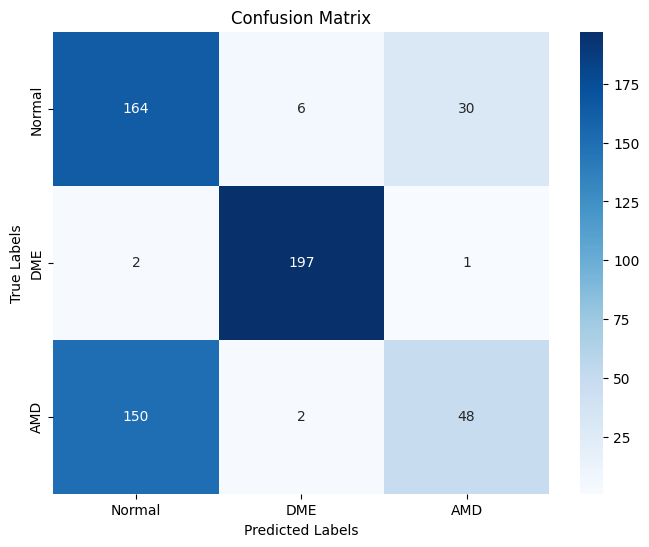

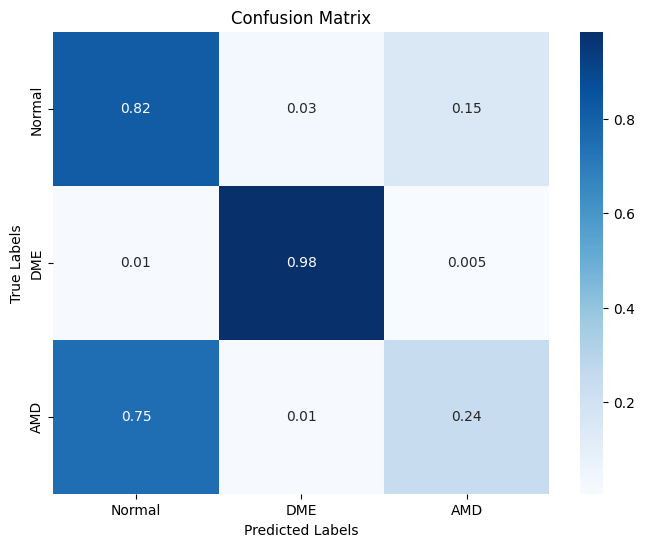

True

In [180]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(label_true, label_predict, labels=['Normal', 'DME', 'AMD'])
conf_matrix_norm = confusion_matrix(label_true, label_predict, labels=['Normal', 'DME', 'AMD'], normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'DME', 'AMD'], yticklabels=['Normal', 'DME', 'AMD'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Convert the heatmap to an image
heatmap_image = np.array(heatmap.get_figure().canvas.renderer.buffer_rgba())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
heatmap_norm = sns.heatmap(conf_matrix_norm, annot=True, cmap='Blues', xticklabels=['Normal', 'DME', 'AMD'], yticklabels=['Normal', 'DME', 'AMD'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
# Convert the heatmap to an image
heatmap_norm_image = np.array(heatmap_norm.get_figure().canvas.renderer.buffer_rgba())

cv2.imwrite('/content/oct_my_trdataset/test/conf_matrix.jpeg', heatmap_image)
cv2.imwrite('/content/oct_my_trdataset/test/conf_matrix_norm.jpeg', heatmap_norm_image)

In [181]:
#copy folders to google drive
shutil.copytree("/content/oct_my_dataset", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dataset")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dataset'

In [182]:
shutil.copytree("/content/oct_my_dictl_dataset", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dictl_dataset")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_dictl_dataset'

In [183]:
shutil.rmtree('/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset'

In [184]:
shutil.copytree("/content/oct_my_trdataset", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/oct_my_trdataset'

In [185]:
shutil.copytree("/content/atoms", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/atoms")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/atoms'

In [186]:
shutil.copytree("/content/runs", "/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/runs")

'/content/drive/MyDrive/oct_classification/macular_dataset_heidelberg/runs'

In [187]:
#@title Dictlearn tests - incomplete

In [ ]:
!git clone https://github.com/permfl/dictlearn.git /content/dictlearn

Cloning into '/content/dictlearn'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 152 (delta 1), reused 2 (delta 0), pack-reused 145
Receiving objects: 100% (152/152), 2.11 MiB | 8.41 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
!pip install dictlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 1.1 MB/s eta 0:00:00


In [ ]:
%cd /content/dictlearn
!pip install --file requirements.txt

/content/dictlearn

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: --file


In [ ]:
!python setup.py install

Installing dictlearn...
Compiling /content/dictlearn/dictlearn/_dictlearn/_dictlearn.pyx because it changed.
Compiling /content/dictlearn/dictlearn/_dictlearn/hessian.pyx because it changed.
[1/2] Cythonizing /content/dictlearn/dictlearn/_dictlearn/_dictlearn.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/dictlearn/dictlearn/_dictlearn/_dictlearn.pxd
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing /content/dictlearn/dictlearn/_dictlearn/hessian.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/dictlearn/dictlearn/_dictlearn/hessian.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running install
/usr/local/lib/python3.10/dist-packag

In [ ]:
import dictlearn as dl
dictionary = dl.dct_dict(256, 8)

AttributeError: module 'dictlearn' has no attribute 'dct_dict'

In [ ]:
import dictlearn as dl
dl.
image = dl.imread('examples/images/house.png')
image_patches = dl.Patches(image, 8)
matrix = image_patches.patches
matrix.shape

AttributeError: module 'dictlearn' has no attribute 'Patches'

In [ ]:
import matplotlib.pyplot as plt
import dictlearn as dl

denoise = dl.Denoise('noisy_image.png')
denoised_image = denoise.train().denoise()
plt.imshow(denoised_image)
plt.show()

AttributeError: module 'dictlearn' has no attribute 'Denoise'

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.1
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.14.0
backcall                         0.2.0
beautifulsoup4                   4.11.2
bidict                           0.22.1
b

In [ ]:
!pip show dictlearn

Name: dictlearn
Version: 0.2.1
Summary: Dictionary Learning Toolbox
Home-page: https://gitlab.com/unibuc/graphomaly/dictionary-learning
Author: Paul Irofti, Denis Ilie-Ablachim, Bogdan Dumitrescu
Author-email: graphomaly@fmi.unibuc.ro
License: UNKNOWN
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, scipy
Required-by: 


In [ ]:
print(dir(dl))
dl.kernels()

['DictionaryLearning', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_dictionary_learning', '_get_fit_handle', 'dictionary_learning', 'kernel_dictionary_learning', 'kernels', 'methods', 'online_dictionary_learning', 'sparse_encode']


In [ ]:
import matplotlib.pyplot as plt
import dictlearn as dl
dl.
inpainter = dl.inpaint('image.png', 'mask.png')
inpainted_image = inpainter.train().inpaint()

plt.subplot(121)
plt.imshow(inpainter.patches.image)
plt.title('Original')

plt.subplot(122)
plt.imshow(inpainted_image)
plt.title('Inpainted')

plt.show()

AttributeError: module 'dictlearn' has no attribute 'inpaint'

In [ ]:
import sys
import dictlearn as dl
import matplotlib.pyplot as plt
import cv2


image = cv2.imread('images/vessel.png')
patches = dl.Patches(image, size=4)
labels = dl.detection.smallest_cluster(patches.patches.T, 2, True)

# Adjust alpha to change the weight for the enhanced image
if len(sys.argv) == 2:
    alpha = float(sys.argv[1])
else:
    alpha = 0.2

vessels = patches.patches * labels
new = alpha*patches.patches + (1 - alpha)*vessels
enhanced = patches.reconstruct(new)

plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(enhanced)
plt.axis('off')
plt.title('Enhanced')

plt.show()

AttributeError: module 'dictlearn' has no attribute 'Patches'

In [ ]:
import sys
import dictlearn as dl
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('/CNV-1016042-1.jpeg')

In [ ]:
import sys
import dictlearn as dl
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('/CNV-1016042-1.jpeg')
patches = dl.Patches(image, size=4)
labels = dl.detection.smallest_cluster(patches.patches.T, 2, True)

# Adjust alpha to change the weight for the enhanced image
if len(sys.argv) == 2:
    alpha = float(sys.argv[1])
else:
    alpha = 0.2

vessels = patches.patches * labels
new = alpha*patches.patches + (1 - alpha)*vessels
enhanced = patches.reconstruct(new)

plt.subplot(121)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(122)
plt.imshow(enhanced)
plt.axis('off')
plt.title('Enhanced')

plt.show()

AttributeError: module 'dictlearn' has no attribute 'Patches'

In [ ]:
from sklearn import datasets

faces = datasets.fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data


In [ ]:
import time

import numpy as np

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.image import extract_patches_2d

print("Learning the dictionary... ")
rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=81, random_state=rng, verbose=True, n_init=3)
patch_size = (30, 30)

buffer = []
t0 = time.time()

# The online learning part: cycle over the whole dataset 6 times
index = 0
for _ in range(6):
    for img in faces.images:
        data = extract_patches_2d(img, patch_size, max_patches=50, random_state=rng)
        data = np.reshape(data, (len(data), -1))
        buffer.append(data)
        index += 1
        if index % 10 == 0:
            data = np.concatenate(buffer, axis=0)
            data -= np.mean(data, axis=0)
            data /= np.std(data, axis=0)
            kmeans.partial_fit(data)
            buffer = []
        if index % 100 == 0:
            print("Partial fit of %4i out of %i" % (index, 6 * len(faces.images)))

dt = time.time() - t0
print("done in %.2fs." % dt)

Learning the dictionary... 
[MiniBatchKMeans] Reassigning 3 cluster centers.
Partial fit of  100 out of 2400
[MiniBatchKMeans] Reassigning 10 cluster centers.
Partial fit of  200 out of 2400
[MiniBatchKMeans] Reassigning 10 cluster centers.
[MiniBatchKMeans] Reassigning 2 cluster centers.
Partial fit of  300 out of 2400
[MiniBatchKMeans] Reassigning 1 cluster centers.
Partial fit of  400 out of 2400
[MiniBatchKMeans] Reassigning 1 cluster centers.
Partial fit of  500 out of 2400
Partial fit of  600 out of 2400
Partial fit of  700 out of 2400
Partial fit of  800 out of 2400
Partial fit of  900 out of 2400
Partial fit of 1000 out of 2400
Partial fit of 1100 out of 2400
Partial fit of 1200 out of 2400
Partial fit of 1300 out of 2400
Partial fit of 1400 out of 2400
Partial fit of 1500 out of 2400
Partial fit of 1600 out of 2400
Partial fit of 1700 out of 2400
Partial fit of 1800 out of 2400
Partial fit of 1900 out of 2400
Partial fit of 2000 out of 2400
Partial fit of 2100 out of 2400
Part

In [ ]:
a = faces.images

In [ ]:
a.dtype

dtype('float32')

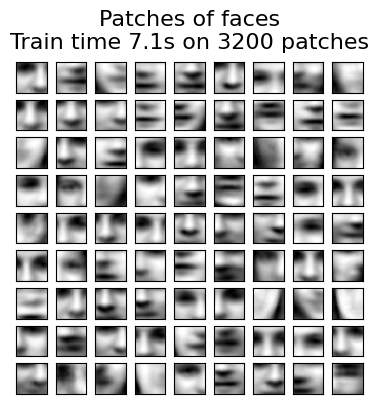

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4.2, 4))
for i, patch in enumerate(kmeans.cluster_centers_):
    plt.subplot(9, 9, i + 1)
    plt.imshow(patch.reshape(patch_size), cmap=plt.cm.gray, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())


plt.suptitle(
    "Patches of faces\nTrain time %.1fs on %d patches" % (dt, 8 * len(faces.images)),
    fontsize=16,
)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()